In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


**Mount to gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip" -d "/content/Dataset"

Archive:  /content/gdrive/MyDrive/Dataset/Cats-and-Dogs-Breed-Clasification.zip
   creating: /content/Dataset/Cats and Dogs Breed Clasification/test/
   creating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_164.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_165.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_166.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_167.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_168.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_169.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasification/test/Abyssinian/Abyssinian_170.jpg  
  inflating: /content/Dataset/Cats and Dogs Breed Clasificatio

In [ ]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

**Image Augmentaion**

In [ ]:
train_path = '/content/Dataset/Cats and Dogs Breed Clasification/train'
test_path = '/content/Dataset/Cats and Dogs Breed Clasification/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

val_set = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

motives_dict = train_set.class_indices
print(motives_dict)

Found 1500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
{'Abyssinian': 0, 'Beagle': 1, 'Bombay': 2, 'British Shorthair': 3, 'Chihuahua': 4, 'Persian': 5, 'Pomeranian': 6, 'Pug': 7, 'Shiba Inu': 8, 'Siamese': 9}


**Use Transfer Learning as Feature Extractor**

In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=1.0,
    pooling='avg' # Add GlobalAvgPool2D() layer as its final layer
)

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
def scheduler(epoch, lr):
  if epoch <= 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-4
TRAIN_STEP = 1500//32
VAL_STEP = 500//32

In [ ]:
clear_session()

model = Sequential([
    base_model,
    Dense(150, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_set,
    validation_data=val_set,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 150)               192150    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1510      
                                                                 
Total params: 2,451,644
Trainable params: 193,660
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/50
46/46 [==============================] - 67s 1s/step - loss: 1.9303 - accuracy: 0.3746 - val_lo

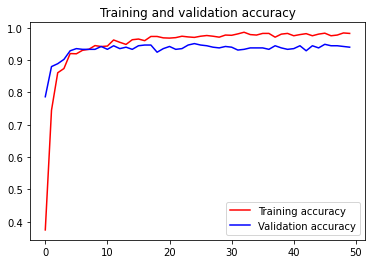

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

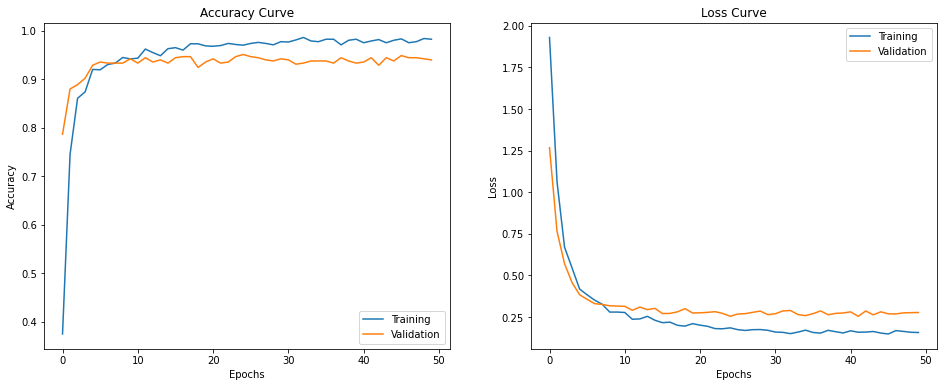

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
test_dir = '/content/Dataset/Cats and Dogs Breed Clasification/test/'

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/Dataset/Cats and Dogs Breed Clasification/test/{motive}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        motives_list = list(motives_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

        # plt.subplot(5, 4, idx+1)
        # plt.title(f'Actual: {motive}\nPrediction: {pred_motive} {pred_confidence:.2f}%')
        # plt.imshow(img)
        # plt.axis('off')
    
    print(f'{motive} Predictions --> {correct_count}/50 correct')
# plt.show()

Abyssinian Predictions --> 48/50 correct
Beagle Predictions --> 49/50 correct
Bombay Predictions --> 49/50 correct
British Shorthair Predictions --> 46/50 correct
Chihuahua Predictions --> 48/50 correct
Persian Predictions --> 45/50 correct
Pomeranian Predictions --> 50/50 correct
Pug Predictions --> 48/50 correct
Shiba Inu Predictions --> 41/50 correct
Siamese Predictions --> 48/50 correct


**Save The Model **

In [ ]:
model_save_path = "saved_model/catsdogsclassifier"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models')
with open('tflite_models/catsdogsclassifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/catsdogsclassifier/assets


INFO:tensorflow:Assets written to: saved_model/catsdogsclassifier/assets


In [ ]:
!zip -r /content/file.zip /content/saved_model/catsdogsclassifier

  adding: content/saved_model/catsdogsclassifier/ (stored 0%)
  adding: content/saved_model/catsdogsclassifier/assets/ (stored 0%)
  adding: content/saved_model/catsdogsclassifier/saved_model.pb (deflated 91%)
  adding: content/saved_model/catsdogsclassifier/variables/ (stored 0%)
  adding: content/saved_model/catsdogsclassifier/variables/variables.index (deflated 75%)
  adding: content/saved_model/catsdogsclassifier/variables/variables.data-00000-of-00001 (deflated 8%)
